In [88]:
from qiskit_ibm_provider import IBMProvider
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from qiskit import pulse, QuantumCircuit,transpile, schedule as build_schedule
from qiskit.circuit import Gate
from scipy.optimize import curve_fit
from get_SVD_direcs_v3 import SVD_direcs
from get_optcal_pulse_v2 import optcal_pulse
import pickle


# path to scripting folder
folder = ''
pulse_index = 29

file = 'results/opt_state' + str(pulse_index) + '.pkl'
fileObj = open(folder+file,'rb')
contents = pickle.load(fileObj)
fileObj.close()
c0 = np.array(contents['params'])


dim = contents['config']['dim']
v=contents['config']['v']
anharm = contents['config']['anharm']
r = contents['config']['r']
v_spec = contents['config']['v_spec']
num_params = len(c0)-1
n = int(num_params/2)
dt = 1/4.5
qubit_number = 17

inputs = [dim,v,anharm,r,0,0,0,0]

In [2]:
provider = IBMProvider(name="dev-iqp")
# provider = IBMProvider(instance="ibm-q-internal/internal-test/bichromatic")
backend = provider.get_backend("test_whiplash")
pi=np.pi

def gaussian(x,a,xo,b,c):
    return a*np.exp(-(x-xo)**2/(2*b))+c

def sin(x,amp,freq,phase,c):
    return amp*np.sin(x*freq+phase)+c

def cos(x,amp,freq,phase,c):
    return amp*np.cos(x*freq+phase)+c

def linear(x,m,b):
    return m*x+b

## Pulse generation - SVD direcs are calculated in here



In [3]:
directions = SVD_direcs(folder,pulse_index)

def get_pulse_w_directions(c_vec,amp=1):
    c0_prime = np.zeros(len(c0))
    c0_prime[:-1] = c0[:-1] + np.tensordot(c_vec, directions, axes=1)
    c0_prime[-1] = c0[-1]
    return optcal_pulse(c0_prime,amp)


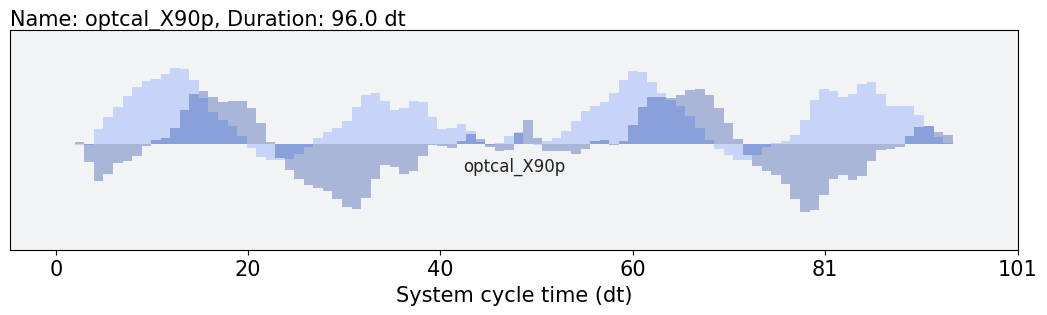

In [4]:
nsamples = int(get_pulse_w_directions([0,0,0,0]).duration)
dur = nsamples * dt
get_pulse_w_directions([0,0,0,0]).draw()



In [5]:
#Run this block of code and skip to the next part...

def optcalpulse_schedule(dir,amplitude=1, qubit_number=17):
        our_pulse = get_pulse_w_directions(dir,amplitude)
        
        with pulse.build(backend,name='opt_sched') as opt_schedule:
            pulse.play(our_pulse,pulse.drive_channel(qubit_number))
        return opt_schedule

def amp_cal(cstar,minamp,maxamp):
    
    def build_circuit_sweepamp(amplitude,qubit_number,c=[0,0,0,0]):
        circ = QuantumCircuit(1,1)
        optcal_gate = Gate('optcal_gate',1,[])

        circ.append(optcal_gate,[0])
        circ.measure(0,0)
        
        schedule = optcalpulse_schedule(c,amplitude,qubit_number)
        circ.add_calibration(optcal_gate,[qubit_number],schedule)
        circ_transpiled = transpile(circ,backend,initial_layout=[qubit_number])
        return circ_transpiled
    
    amp_list = np.linspace(minamp,maxamp,150)
    circuits = [build_circuit_sweepamp(amp0,qubit_number,c=cstar) for amp0 in amp_list]

    total_shots = 300
    counts = backend.run(circuits, shots=total_shots).result().get_counts()

    def get_pops(npts,total_shots):
        populations = []
        for i in range(npts):
            counts_temp = counts[i]
            zeros = 0
            ones = 0
            for key, val in counts_temp.items():
                if list(key)[-1] == '1':
                    ones += val
                else:
                    zeros += val
            populations = populations + [[i, (ones) / total_shots]]
        data = np.array(populations)
        return data
    
    data_expt = get_pops(amp_list.shape[0],total_shots)
    return amp_list, data_expt

def amp_simulation(cstar):
    optcal_pi2_pulse = get_pulse_w_directions(cstar)

    from master_fxns import get_hamiltonian
    from qiskit_dynamics import Solver

    static_hamiltonian,drive_hamiltonian,_ = get_hamiltonian(inputs)

    single_q_solver = Solver(
        static_hamiltonian=static_hamiltonian,
        hamiltonian_operators=[drive_hamiltonian],
        rotating_frame=static_hamiltonian,
        hamiltonian_channels=['d0'],
        channel_carrier_freqs={'d0': v},
        dt=dt
    )

    scale_factors = np.linspace(0., 2, 100)

    schedules = []
    for scale_factor in scale_factors:
        scaled_pi2 = pulse.Waveform(scale_factor * optcal_pi2_pulse.samples, name='X90p', limit_amplitude=False)
        
        with pulse.build() as sched:
            pulse.play(scaled_pi2, pulse.DriveChannel(0))
        
        schedules.append(sched)

    y0 = np.zeros(dim * dim, dtype=complex)
    y0[0] = 1.
    Tf = optcal_pi2_pulse.duration * dt

    results = single_q_solver.solve(
        t_span=np.array([0, Tf]),
        y0=y0,
        signals=schedules,
        method='jax_odeint',
        atol=1e-8,
        rtol=1e-8)

    from matplotlib import pyplot as plt

    # for each result, get the final state, and compute prob it is in first excited state
    sim = [np.abs(result.y[-1][1])**2 for result in results]
    simx = scale_factors
    return simx,sim


def run_amp_expt(cstar,minamp,maxamp):
    ampx,data = amp_cal(cstar,minamp,maxamp)
    simx,sim = amp_simulation(cstar)
    return ampx,data,simx,sim

def rescale_amp(factor,ampx,data,simx,sim):
    popt,_ = curve_fit(cos,simx/factor,sim,[-0.5,.6,0,0.5])
    popt2,_ = curve_fit(cos,ampx[1:],data[1:,1],[-0.5,.7,0,0.5])

    amp_pi2 = (np.arccos((0.5-popt[3])/popt[0])-popt[2])/popt[1]
    amp_opt = amp_pi2

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    ax1.scatter(ampx[1:], data[1:, 1], alpha=0.4, marker="o", color='b',label='Data')
    ax1.scatter(simx/factor, sim, alpha=0.4, marker="o", color='r',label='Sim')
    ax1.plot(ampx,cos(ampx,*popt2),color='pink')
    ax1.plot(simx/factor,cos(simx/factor,*popt))

    ax2.scatter(ampx,abs(cos(ampx,*popt)-cos(ampx,*popt2)),color='k')
    ax2.axhline(0.005)
    ax2.set_xlim(amp_opt-.5,amp_opt+.5)
    ax2.set_ylim(0,0.05)


    ax1.axvline(amp_opt,color='gray',linestyle='dashed')
    ax2.axvline(amp_opt,color='gray',linestyle='dashed')
    fig.suptitle("Amplitude Robustness Plot After Rescaling")
    ax1.set_xlabel('Amplitude')
    ax1.set_label(r'P(1)')
    ax1.legend()
    return amp_opt

def find_phaserot(amplitude,cstar):
    def find_vzrot(amplitude, cancelling_frame_shift,dir):
        circ = QuantumCircuit(1,1)
        optcal_gate = Gate('optcal_gate',1,[])
        circ.append(optcal_gate,[0])
        circ.barrier()
        circ.rz(cancelling_frame_shift,0)
        circ.barrier()
        circ.append(optcal_gate,[0])
        circ.barrier()
        circ.rz(cancelling_frame_shift,0)
        circ.barrier()
        circ.measure(0,0)
        
        schedule = optcalpulse_schedule(dir,amplitude,qubit_number)
        circ.add_calibration(optcal_gate,[qubit_number],schedule)
        circ_transpiled = transpile(circ,backend,initial_layout=[qubit_number])
        return circ_transpiled
    
    N = 60
    rotangle = np.linspace(-2*pi,2*pi,N)
    schedules = [find_vzrot(amp_opt, phi, cstar) for phi in rotangle]   
    total_shots = 300
    counts = backend.run(schedules, shots=total_shots).result().get_counts()

    z_expectations = []
    for i in range(int(N)):
        counts_temp = counts[i]
        zeros = 0
        
        ones = 0
        for key, val in counts_temp.items():
            if list(key)[-1] == '1':
                ones += val
            else:
                zeros += val

        z_expectations = z_expectations + [[i, (zeros - ones) / total_shots]]

    data = np.array(z_expectations)
    popt,pcov = curve_fit(cos,rotangle,data[:,1],p0=[1,1,0,0])

    figure = plt.figure(figsize=(3, 1.5), dpi=120, facecolor='w')
    ax = figure.add_subplot(111)

    ax.scatter(rotangle, data[:, 1], alpha=0.3, marker="o")
    ax.plot(rotangle,cos(rotangle,*popt),color='b')
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel('<Z>')
    ax.set_ylim([-1.1,1.1])
    plt.axhline(y=0., color='r', linestyle='-')
    phase_rot = popt[2]
    fit_amp = popt[0]
    print('The phase rotation is %.15f rad and the amplitude of the X(pi) rotation is %.3f' %(phase_rot,fit_amp))
    return phase_rot

def build_circuit_pi2_tuneup(number,amplitude,frame_shift,qubit_number,phase_rot,c=[0,0,0,0]):
    circ = QuantumCircuit(1,1)
    optcal_gate = Gate('optcal_gate',1,[])

    circ.append(optcal_gate,[0])
    circ.barrier()
    circ.rz(phase_rot,0)
    circ.barrier()
    for n in range(number):
        circ.append(optcal_gate,[0])
        circ.barrier()
        circ.rz(phase_rot,0)
        circ.barrier()
        circ.append(optcal_gate,[0])
        circ.barrier()
        circ.rz(phase_rot+frame_shift,0)
        circ.barrier()
    circ.measure(0,0)
    
    schedule = optcalpulse_schedule(c,amplitude,qubit_number)
    circ.add_calibration(optcal_gate,[qubit_number],schedule)
    circ_transpiled = transpile(circ,backend,initial_layout=[qubit_number])
    return circ_transpiled

In [9]:
#This generates experimental data of amplitude scaling and simulated data.
cstar = [0,0,0,0]
ampx,data,simx,sim = run_amp_expt(cstar,0,1.7)


0.8441439653171511


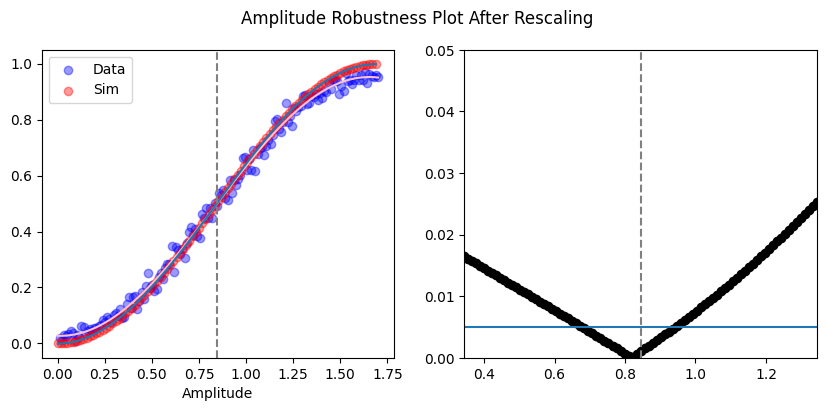

In [17]:
#The left-hand plot shows simulated data (red) and experimental data (blue) for amplitude scaling.
#The right hand plot shows the difference between theory and experiment in black. I try to adjust the rescaling value so that the error is lowest where the gray dashed line is. 
#The blue horizontal line is just a 0.5% error guide to the eye.
rescale = 1.185


amp_opt = rescale_amp(rescale,ampx,data,simx,sim)
print(amp_opt)

The phase rotation is 0.039978207387561 rad and the amplitude of the X(pi) rotation is -0.948


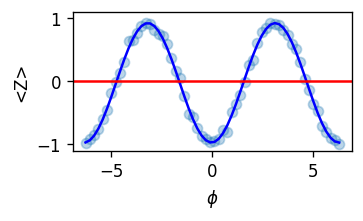

In [122]:
cstar = [.0068,-.24,.16,-0.16]
phase_rot = find_phaserot(amp_opt,cstar)

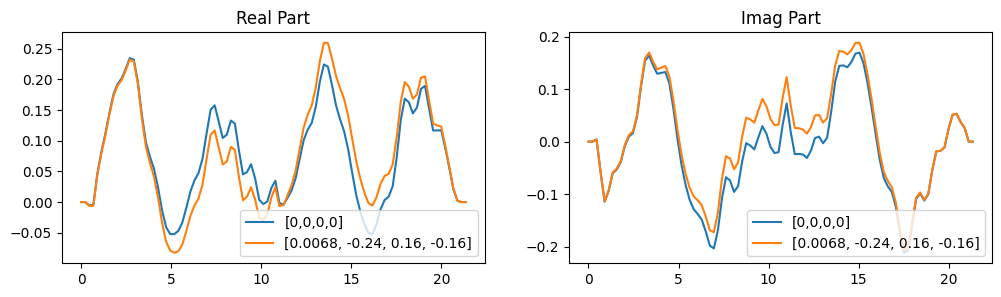

In [123]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,3),dpi=100)
pulse1 = get_pulse_w_directions([0,0,0,0],amp_opt).samples
pulse2 = get_pulse_w_directions(cstar,amp_opt).samples
time = np.linspace(0,dur,nsamples)
ax1.plot(time,np.real(pulse1),label='[0,0,0,0]')
ax1.plot(time,np.real(pulse2),label=str(cstar))
ax2.plot(time,np.imag(pulse1),label='[0,0,0,0]')

ax2.plot(time,np.imag(pulse2),label=str(cstar))
ax1.set_title('Real Part')
ax2.set_title('Imag Part')
ax1.legend()
ax2.legend()




## Manual Tries
All you need to do here is pick one value of the direction vector to vary and place a 'p' in that index. Then change the np.linspace in plist to try different values of p.

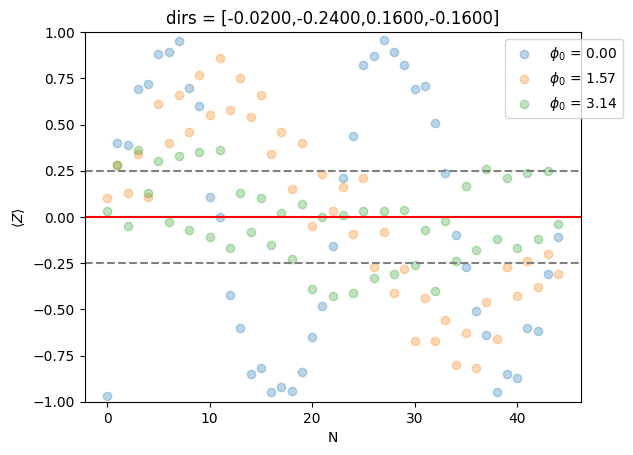

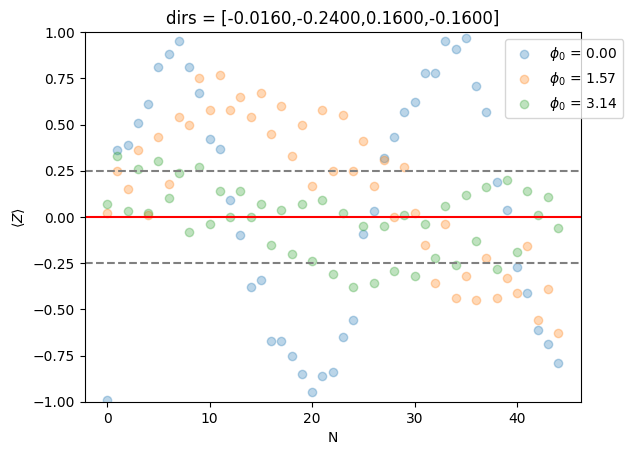

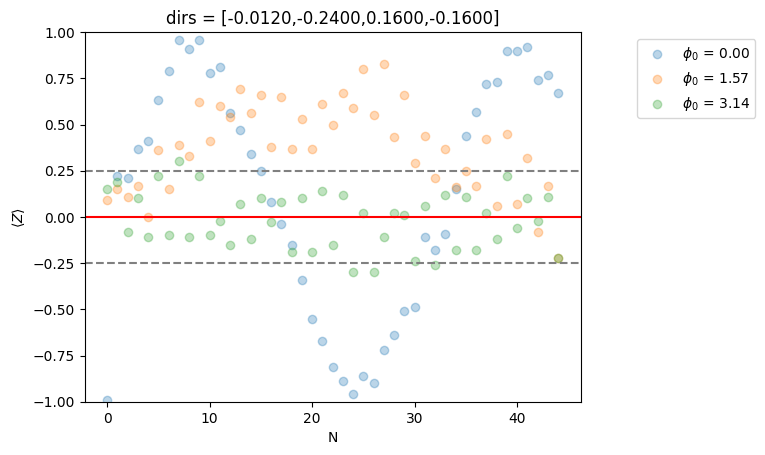

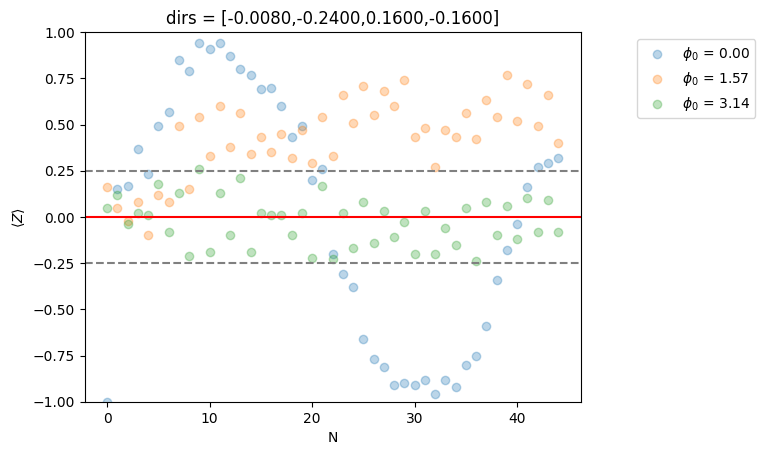

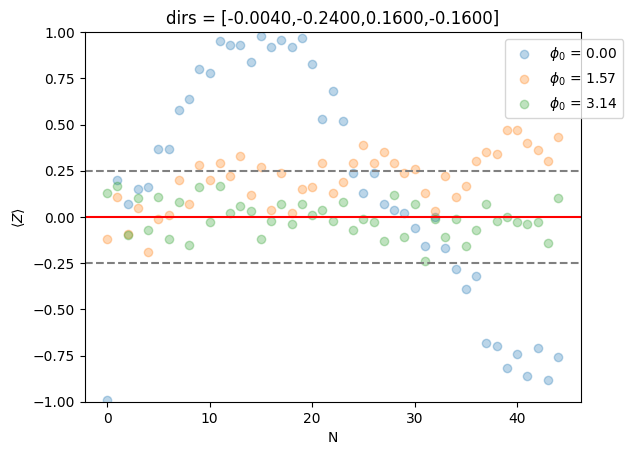

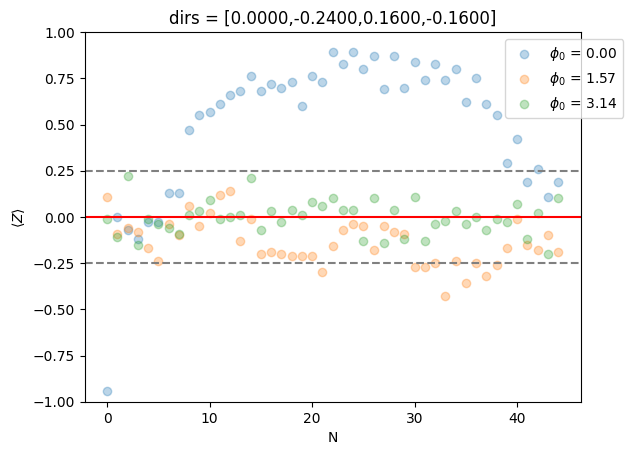

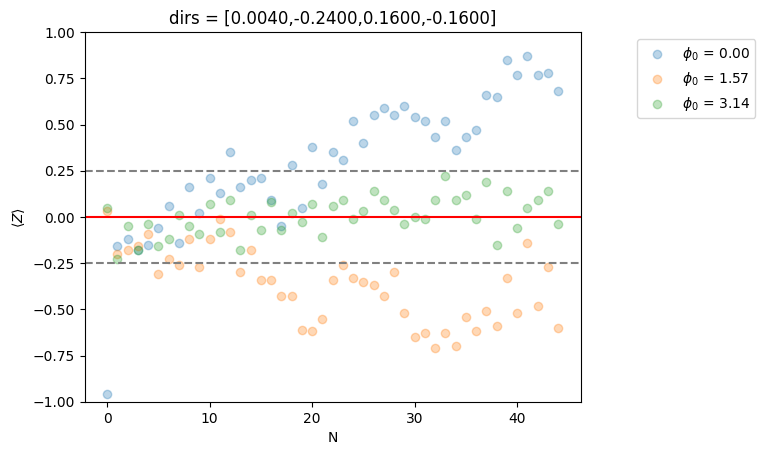

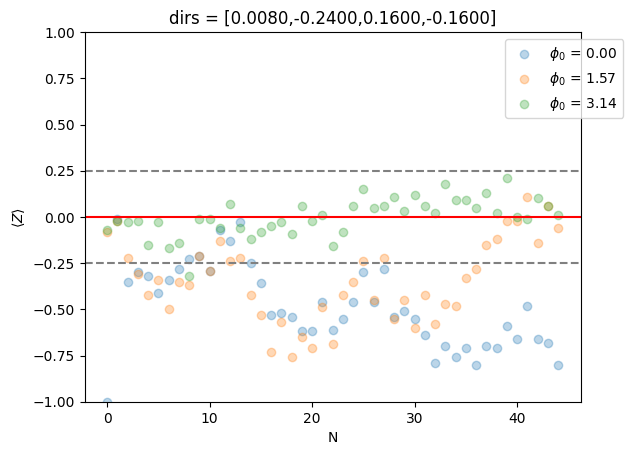

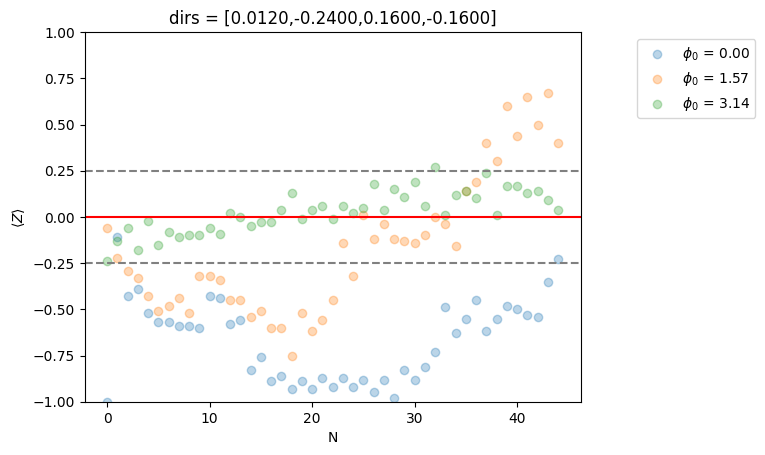

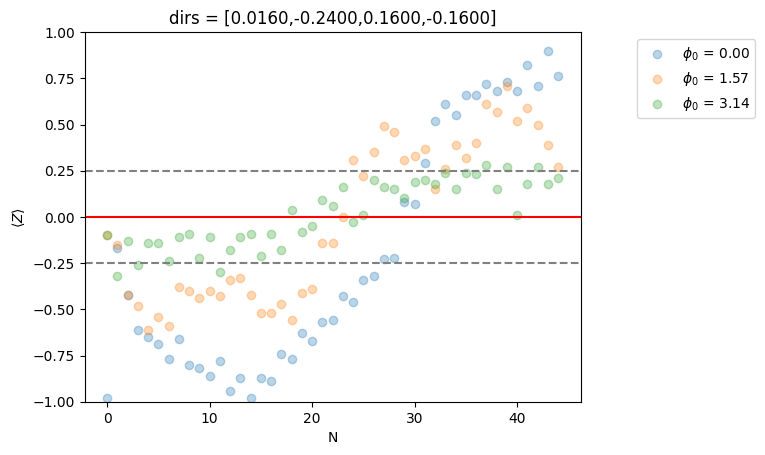

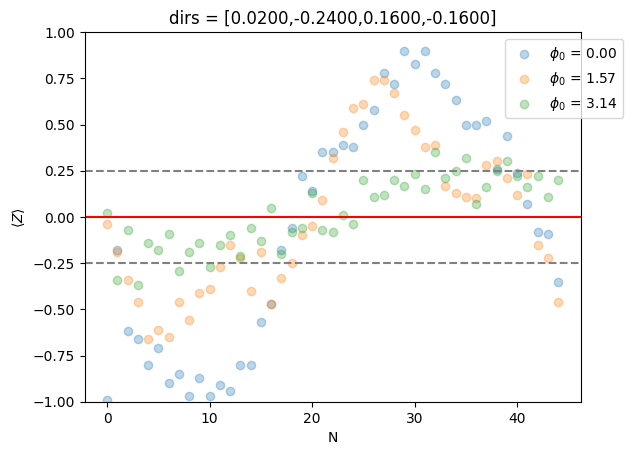

In [124]:
N = 45
phi_setlist=np.linspace(0,np.pi,3)
# phi_setlist = [np.pi/2]
plist = np.linspace(-.02,0.02,11) #change these np.linspace inputs to sample a different parameter range
# plist = np.zeros(1)

circuits = []
clist = []
for p in plist:
    c = [p,-.24,.16,-0.16] #place "p" in one of the indicies of c and put constants in the other 3
    clist.append(c)
    for i in np.arange(N):
        for phi in phi_setlist:
            circuits.append(build_circuit_pi2_tuneup(i, amp_opt, phi, qubit_number,phase_rot,c=c))

total_shots = 200
counts = backend.run(circuits, shots=total_shots).result().get_counts()

for p in range(plist.shape[0]):
    z_expectations = []
    length = int(len(phi_setlist) * N)

    for i in range(length):
        counts_temp = counts[int(p*length + i)]
        zeros = 0
        
        ones = 0
        for key, val in counts_temp.items():
            if list(key)[-1] == '1':
                ones += val
            else:
                zeros += val

        z_expectations = z_expectations + [[i, (zeros - ones) / total_shots]]

    data_3 = np.array(z_expectations)

    for i in range(len(phi_setlist)):
        plt.scatter(np.arange(N), np.cos(np.pi * np.arange(N)) * data_3[i::len(phi_setlist), 1], alpha=0.3, marker="o",label=r'$\phi_0$ = %.2f' %(phi_setlist[i]))
    
    plt.xlabel('N')
    plt.ylabel(r'$\langle Z \rangle$')
    plt.ylim([-1,1])
    plt.legend(bbox_to_anchor=(1.1,1.))
    plt.axhline(y=0., color='r', linestyle='-')
    plt.axhline(y=0.25,color='gray',linestyle='--')
    plt.axhline(y=-0.25,color='gray',linestyle='--')
    plt.title('dirs = [%.4f,%.4f,%.4f,%.4f]'%(clist[p][0],clist[p][1],clist[p][2],clist[p][3]))
    plt.show()
    plt.close()

In [ ]:
phase_rot

In [ ]:
get_pulse_w_directions(cstar,amp_opt).samples